# Temperature dependent variable bounds verification

## Construct 2nd Level Reactive Flash Model

In [1]:
import sys
import os
import pickle
sys.path.append(os.path.abspath('..'))

In [2]:
from pyomo import environ as pe
from global_sets.component import m

from stages.reactive_stage import reactive_stage_rule

from utility.display_utility import trans_product_mole, trans_product_mass, beautify2
from utility.model_utility import add_dual, update_dual, check_DOF

model = pe.ConcreteModel()

In [3]:
model.TRAY = pe.RangeSet(1,1)

In [4]:
model.reactive = pe.Block(model.TRAY,rule=reactive_stage_rule)

> Importing Reactive Stage......
> Adding the following local variable:
------------------------------------
| reactive[1].x_
| reactive[1].y_
| reactive[1].x
| reactive[1].y
| reactive[1].z
| reactive[1].L
| reactive[1].V
| reactive[1].F
| reactive[1].H_L_
| reactive[1].H_V_
| reactive[1].H_L
| reactive[1].H_V
| reactive[1].H_F
| reactive[1].T
| reactive[1].T_F
| reactive[1].P
| reactive[1].f_V
| reactive[1].f_L
| reactive[1].cat
| reactive[1].Q_main
| reactive[1].r_total_comp
| reactive[1].PR_L
| reactive[1].PR_V
------------------------------------

> Importing Kinetics Blocks......
> Adding the following local variable:
--------------------------------------------------
| reactive[1].kinetics_block.k_FT
| reactive[1].kinetics_block.r_FT_total
| reactive[1].kinetics_block.g0_FT
| reactive[1].kinetics_block.alpha
| reactive[1].kinetics_block.r_FT_cnum
| reactive[1].kinetics_block.r_FT_comp
| reactive[1].kinetics_block.k_WGS
| reactive[1].kinetics_block.Ke_WGS
| reactive[1].kinetics_b

In [5]:
model.reactive[model.TRAY.last()].V['in'].fix(0)
model.reactive[model.TRAY.first()].L['in'].fix(0)
for i in m.COMP_TOTAL:
    model.reactive[model.TRAY.last()].y_['in',i].fix(0)
    model.reactive[model.TRAY.first()].x_['in',i].fix(0)
model.reactive[model.TRAY.last()].H_V_['in'].fix(0)
model.reactive[model.TRAY.first()].H_L_['in'].fix(0)

for j in model.reactive:
    model.reactive[j].V['R'].fix(0)
    model.reactive[j].L['R'].fix(0)
    model.reactive[j].H_V_['R'].fix(0)
    model.reactive[j].H_L_['R'].fix(0)
    model.reactive[j].V['P'].fix(0)
    model.reactive[j].L['P'].fix(0)
    for i in m.COMP_TOTAL:
        model.reactive[j].y_['R',i].fix(0)
        model.reactive[j].x_['R',i].fix(0)

In [6]:
for j in model.reactive:
    model.reactive[j].cat.fix(3000)
    model.reactive[j].P.fix(20)
    model.reactive[j].VLE_block.n_ave.fix(20)
    
    model.reactive[j].F.fix(1)
    model.reactive[j].T_F.fix(200+273.15)
    model.reactive[j].z['CO'].fix(1/(1+0.8)-0.01/2)
    model.reactive[j].z['H2'].fix(0.8/(1+0.8)-0.01/2)
    model.reactive[j].z['C30H62'].fix(0.01)
    model.reactive[j].T.setub(300+273.15)
#     model.reactive[j].Q_main.fix(0)

In [7]:
opt = pe.SolverFactory('ipopt')
opt.options['print_user_options'] = 'yes'
opt.options['linear_scaling_on_demand'] = 'no'
opt.options['max_iter'] = 7000
add_dual(pe,model)

Created the follow pyomo suffixes:
ipopt_zL_out, ipopt_zU_out, ipopt_zL_in, ipopt_zU_in, dual


In [8]:
check_DOF(pe,model)

Active Equality Constraints:	 1184
Active Inequality Constraints:	 1
Active Variables:		 1522
Fixed Variables:		 334
DOF:				 4


In [9]:
model.obj = pe.Objective(expr = sum(model.reactive[j].T for j in model.reactive), sense=pe.maximize)
results = opt.solve(model,tee=True)
update_dual(pe,model)

Ipopt 3.11.1: print_user_options=yes
linear_scaling_on_demand=no
max_iter=7000


List of user-set options:

                                    Name   Value                used
                linear_scaling_on_demand = no                     no
                                max_iter = 7000                  yes
                      print_user_options = yes                   yes

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzer

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 -5.1360044e+002 6.49e+000 6.46e+005  -1.7 7.61e+004    -  4.07e-001 9.31e-001f  1
  71 -5.1437144e+002 5.76e+000 8.68e+005  -1.7 7.62e+003    -  1.00e+000 1.49e-001h  1
  72 -5.1886859e+002 8.37e+000 1.53e+006  -1.7 6.65e+003    -  2.42e-001 1.00e+000h  1
  73 -5.2023643e+002 7.18e+000 3.11e+006  -1.7 9.23e+002    -  1.00e+000 2.35e-001h  1
  74 -5.2496204e+002 9.42e+000 3.92e+007  -1.7 7.55e+002    -  1.46e-001 1.00e+000f  1
  75 -5.2583709e+002 8.67e+000 3.35e+007  -1.7 1.26e+003    -  1.00e+000 1.14e-001h  1
  76 -5.3087561e+002 1.09e+001 3.91e+007  -1.7 8.30e+002    -  2.29e-001 1.00e+000f  1
  77 -5.3205190e+002 9.43e+000 2.93e+007  -1.7 1.05e+003    -  1.00e+000 1.90e-001h  1
  78 -5.3654305e+002 1.03e+001 2.69e+007  -1.7 9.10e+002    -  2.99e-001 8.40e-001f  1
  79 -5.3893669e+002 7.88e+000 2.69e+007  -1.7 8.63e+002    -  2.31e-001 4.83e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d|

## Sweep Temperature from 200C to 300C

In [10]:
model.reactive[1].VLE_block.COMP_NONHENRY.pprint()

COMP_NONHENRY : Dim=0, Dimen=1, Size=70, Domain=None, Ordered=False, Bounds=None
    Virtual


In [11]:
import numpy as np
from matplotlib import pyplot as plt

In [12]:
rf_data = {}
rf_data['T'] = []

for i in m.COMP_TOTAL:
    rf_data['dH_V',i] = []
    rf_data['dH_L',i] = []
    rf_data['dH_vap',i] = []
    rf_data['V_L',i] = []
    rf_data['poynting',i]=[]

for i in model.reactive[1].VLE_block.COMP_HENRY:
    rf_data['Hen',i] = []
    rf_data['Hen0',i] = []
    
for i in model.reactive[1].VLE_block.COMP_NONHENRY:
    rf_data['gamma',i] = []
    rf_data['P_sat',i] = []
    rf_data['P_sat_Y',i] = []

rf_data['k_FT'] = []; rf_data['g0_FT'] = []; rf_data['alpha'] = []; rf_data['k_WGS'] = []; rf_data['Ke_WGS'] = [];
rf_data['P_sat_dY0'] = []; rf_data['P_sat_dY_inf'] = []; rf_data['Hen_ref'] = []; rf_data['Hen0_ref'] = []; rf_data['gamma_ref'] = [];
rf_data['V_L_dY0'] = []; rf_data['V_L_dY_inf'] = [];


Trange = np.arange(300+273.15, 200+273.15, -2)

for Tub in Trange:
    for j in model.reactive:
        model.reactive[j].T.setub(Tub)
        results = opt.solve(model, tee=False)
        update_dual(pe,model)
        print('Solved, Solution T = {} K'.format(model.reactive[j].T.value))

        rf_data['T'].append(model.reactive[1].T.value)

        for i in m.COMP_TOTAL:
            rf_data['dH_V',i].append(model.reactive[j].energy_block.dH_V[i].value)
            rf_data['dH_L',i].append(model.reactive[j].energy_block.dH_L[i].value)
            rf_data['dH_vap',i].append(model.reactive[j].energy_block.dH_vap[i].value)
            rf_data['V_L',i].append(model.reactive[j].VLE_block.V_L[i].value)
            rf_data['poynting',i].append(model.reactive[j].VLE_block.poynting[i].value)
        
        rf_data['k_FT'].append(model.reactive[j].kinetics_block.k_FT.value)
        rf_data['g0_FT'].append(model.reactive[j].kinetics_block.g0_FT.value)
        rf_data['alpha'].append(model.reactive[j].kinetics_block.alpha.value)
        rf_data['k_WGS'].append(model.reactive[j].kinetics_block.k_WGS.value)
        rf_data['Ke_WGS'].append(model.reactive[j].kinetics_block.Ke_WGS.value)

        for i in model.reactive[1].VLE_block.COMP_HENRY:
            rf_data['Hen',i].append(model.reactive[j].VLE_block.Hen[i].value)
            rf_data['Hen0',i].append(model.reactive[j].VLE_block.Hen0[i].value)
        
        for i in model.reactive[1].VLE_block.COMP_NONHENRY:
            rf_data['gamma',i].append(model.reactive[j].VLE_block.gamma[i].value)
            rf_data['P_sat',i].append(model.reactive[j].VLE_block.P_sat[i].value)
            rf_data['P_sat_Y',i].append(model.reactive[j].VLE_block.P_sat_Y[i].value)

        rf_data['P_sat_dY0'].append(model.reactive[j].VLE_block.P_sat_dY0.value)
        rf_data['P_sat_dY_inf'].append(model.reactive[j].VLE_block.P_sat_dY_inf.value)
        rf_data['V_L_dY0'].append(model.reactive[j].VLE_block.V_L_dY0.value)
        rf_data['V_L_dY_inf'].append(model.reactive[j].VLE_block.V_L_dY_inf.value)        
        rf_data['Hen_ref'].append(model.reactive[j].VLE_block.Hen_ref.value)
        rf_data['Hen0_ref'].append(model.reactive[j].VLE_block.Hen0_ref.value)
        rf_data['gamma_ref'].append(model.reactive[j].VLE_block.gamma_ref.value)

Solved, Solution T = 573.15 K
Solved, Solution T = 571.15 K
Solved, Solution T = 569.15 K
Solved, Solution T = 567.15 K
Solved, Solution T = 565.15 K
Solved, Solution T = 563.15 K
Solved, Solution T = 561.15 K
Solved, Solution T = 559.15 K
Solved, Solution T = 557.15 K
Solved, Solution T = 555.15 K
Solved, Solution T = 553.15 K
Solved, Solution T = 551.15 K
Solved, Solution T = 549.15 K
Solved, Solution T = 547.15 K
Solved, Solution T = 545.15 K
Solved, Solution T = 543.15 K
Solved, Solution T = 541.15 K
Solved, Solution T = 539.15 K
Solved, Solution T = 537.15 K
Solved, Solution T = 535.15 K
Solved, Solution T = 533.15 K
Solved, Solution T = 531.15 K
Solved, Solution T = 529.15 K
Solved, Solution T = 527.15 K
Solved, Solution T = 525.15 K
Solved, Solution T = 523.15 K
Solved, Solution T = 521.15 K
Solved, Solution T = 519.15 K
Solved, Solution T = 517.15 K
Solved, Solution T = 515.15 K
Solved, Solution T = 513.15 K
Solved, Solution T = 511.15 K
Solved, Solution T = 509.15 K
Solved, So

## Bounded Variables vs Temperature

### Energy Block

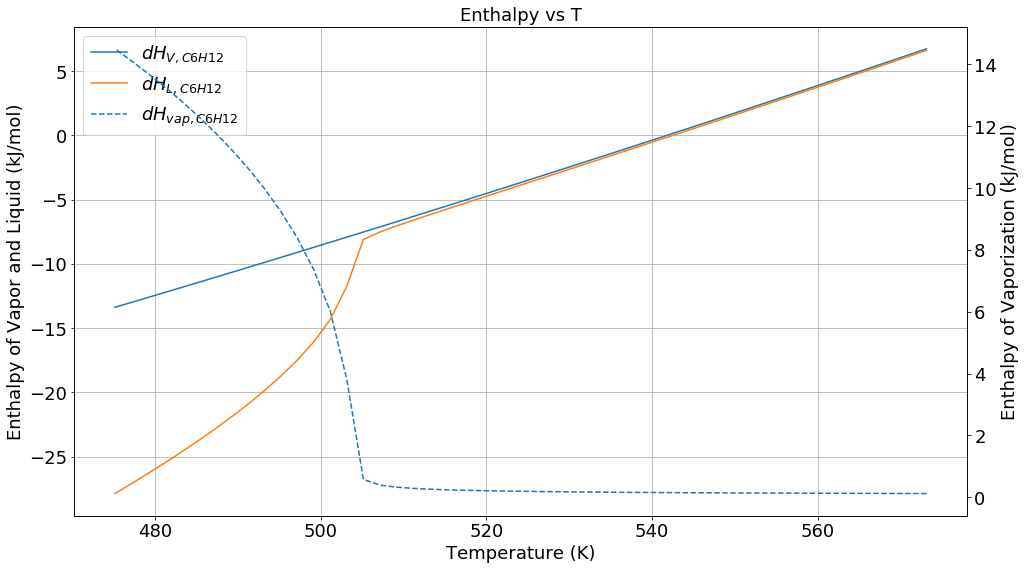

In [13]:
fig, ax1 = plt.subplots(figsize=(16,9))
line1 = ax1.plot(rf_data['T'],rf_data['dH_V','C6H12'])
line2 = ax1.plot(rf_data['T'],rf_data['dH_L','C6H12'])
ax1.set_ylabel('Enthalpy of Vapor and Liquid (kJ/mol)', color='K',fontsize=18)
ax1.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax1.tick_params('y', colors='k',labelsize=18)
ax1.tick_params('x', colors='k',labelsize=18)
ax1.grid()

ax2 = ax1.twinx()
line3 = ax2.plot(rf_data['T'],rf_data['dH_vap','C6H12'], '--')
ax2.set_ylabel('Enthalpy of Vaporization (kJ/mol)', color='K',fontsize=18)
ax2.tick_params('y', colors='k',labelsize=18)

ax1.legend(line1+line2+line3,['$dH_{V,C6H12}$','$dH_{L,C6H12}$','$dH_{vap,C6H12}$'],fontsize=18)
ax1.set_title('Enthalpy vs T',fontsize=18)
plt.show()

### Kinetics Block

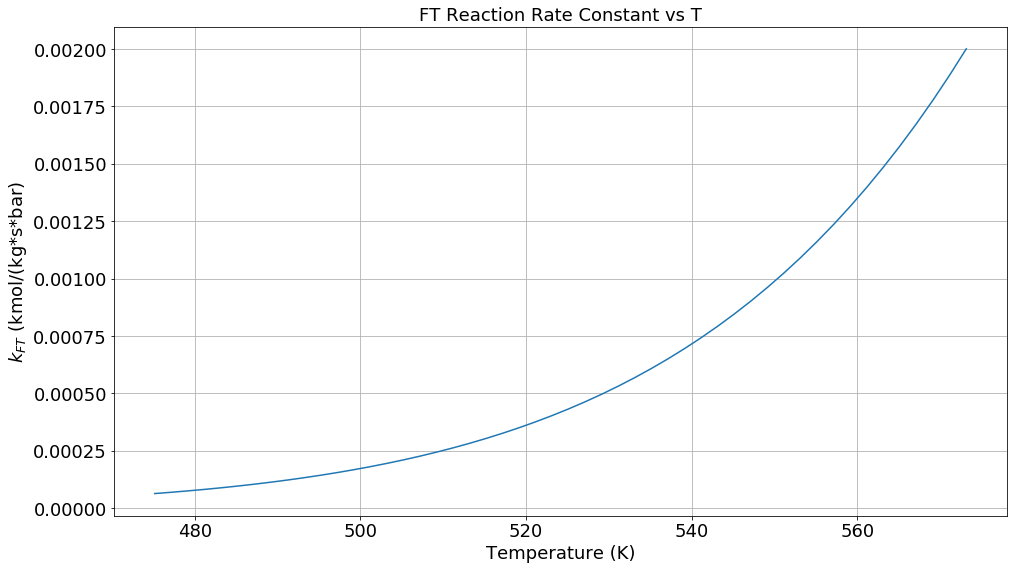

In [14]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['k_FT'])
ax.set_ylabel('$k_{FT}$ (kmol/(kg*s*bar)', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.set_title('FT Reaction Rate Constant vs T',fontsize=18)
plt.show()

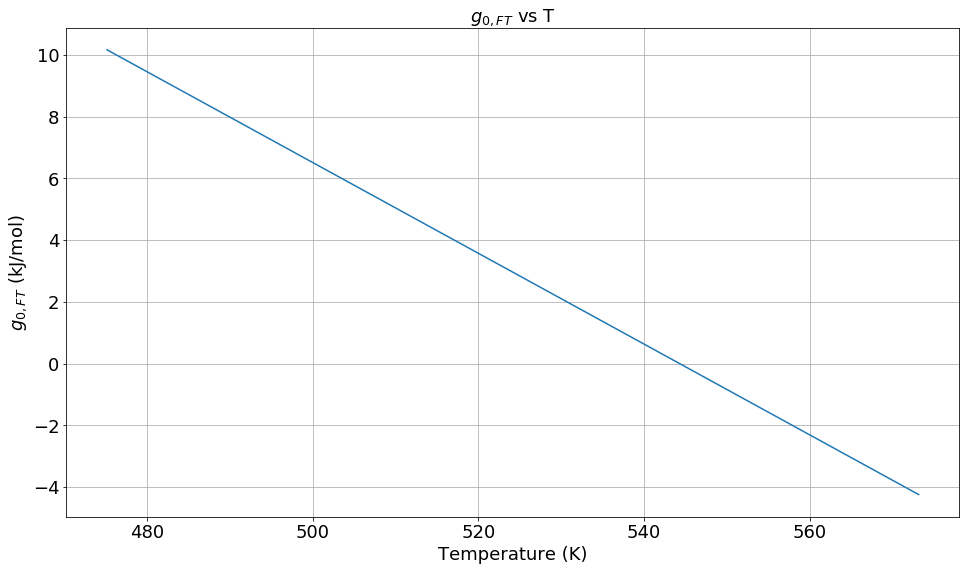

In [15]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['g0_FT'])
ax.set_ylabel('$g_{0,FT}$ (kJ/mol)', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.set_title('$g_{0,FT}$ vs T',fontsize=18)
plt.show()

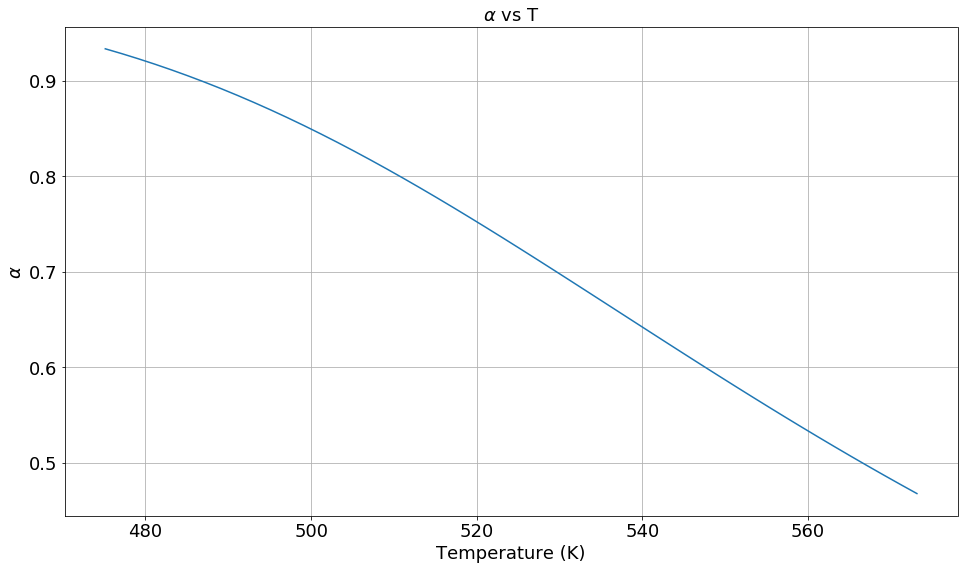

In [16]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['alpha'])
ax.set_ylabel('$\\alpha$', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.set_title('$\\alpha$ vs T',fontsize=18)
plt.show()

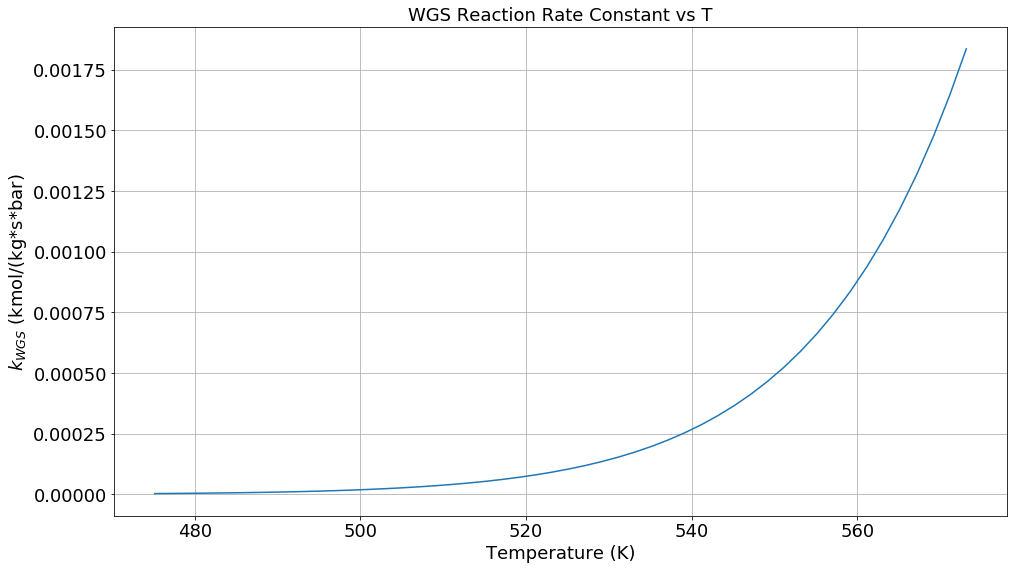

In [17]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['k_WGS'])
ax.set_ylabel('$k_{WGS}$ (kmol/(kg*s*bar)', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.set_title('WGS Reaction Rate Constant vs T',fontsize=18)
plt.show()

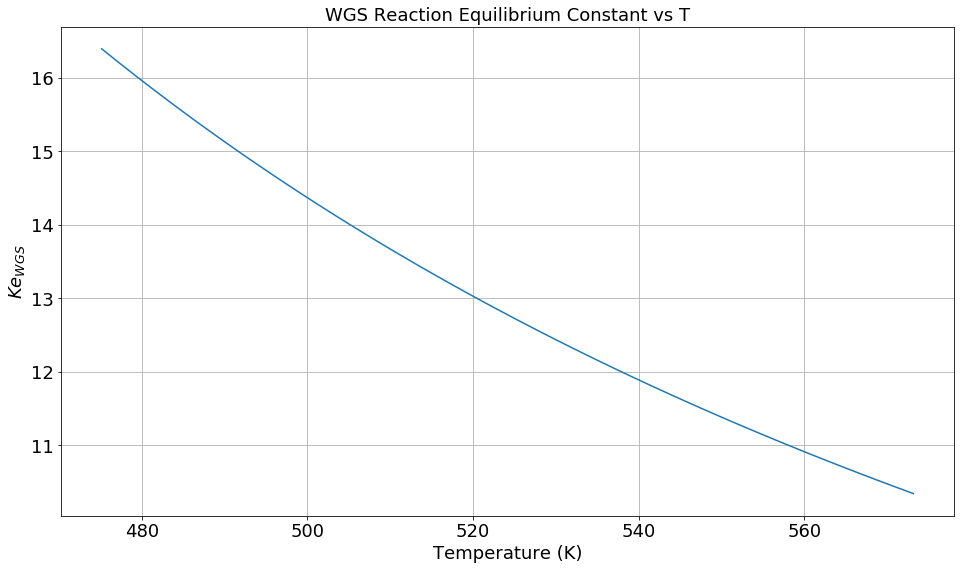

In [18]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['Ke_WGS'])
ax.set_ylabel('$Ke_{WGS}$', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.set_title('WGS Reaction Equilibrium Constant vs T',fontsize=18)
plt.show()

### VLE Block

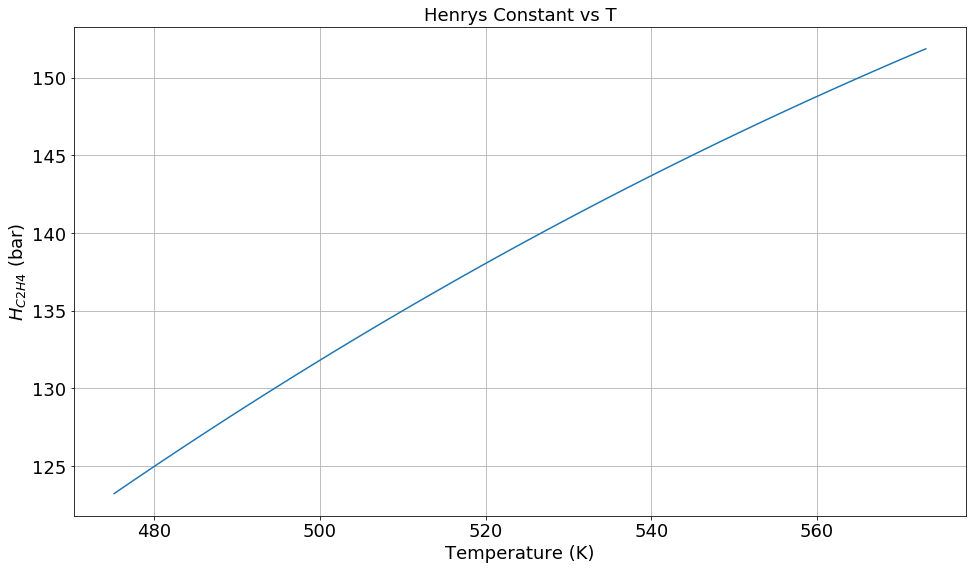

In [19]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['Hen','C2H4'])
ax.set_ylabel('$H_{C2H4}$ (bar)', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.set_title('Henrys Constant vs T',fontsize=18)
plt.show()

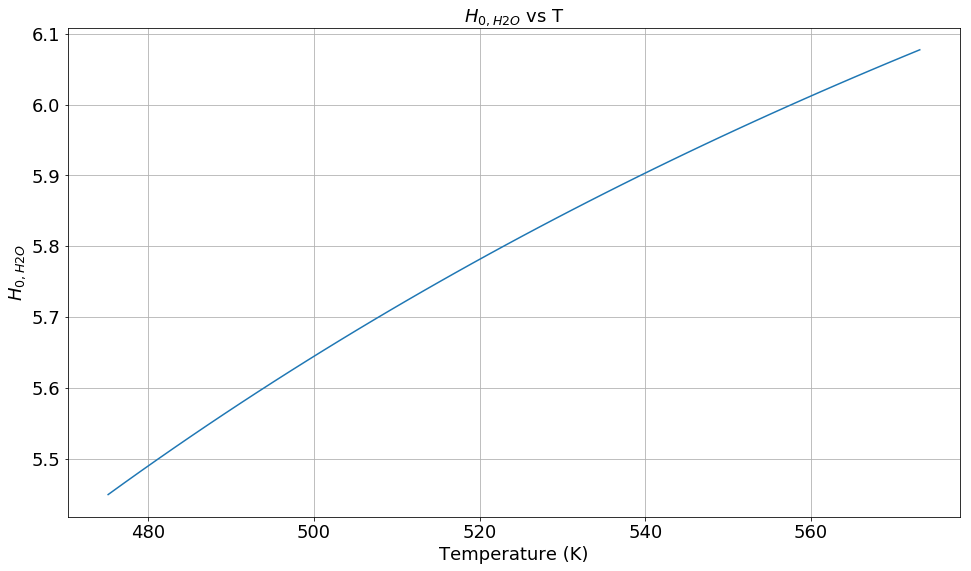

In [20]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['Hen0','H2O'])
ax.set_ylabel('$H_{0,H2O}$', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.set_title('$H_{0,H2O}$ vs T',fontsize=18)
plt.show()

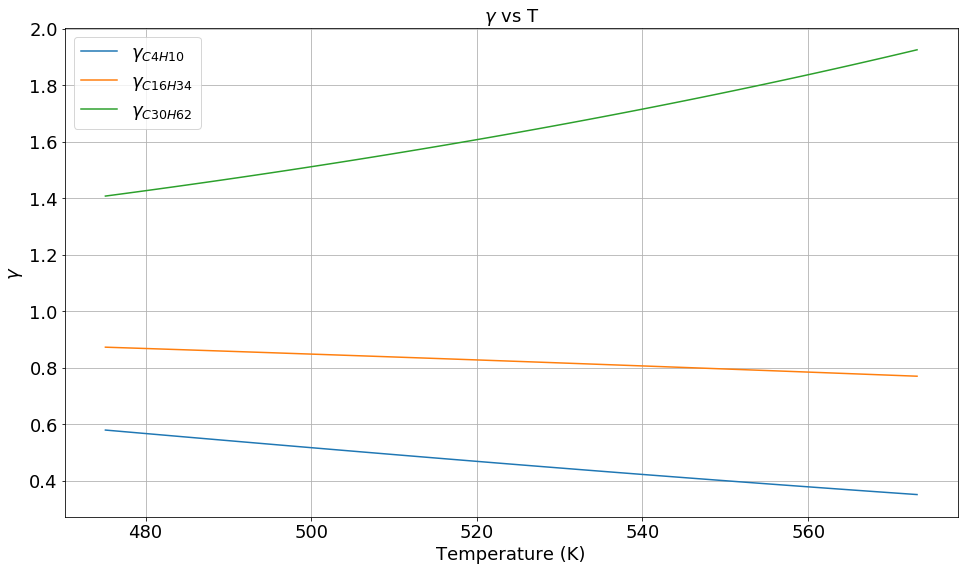

In [21]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['gamma','C4H10'])
ax.plot(rf_data['T'],rf_data['gamma','C16H34'])
ax.plot(rf_data['T'],rf_data['gamma','C30H62'])
ax.set_ylabel('$\gamma$', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.legend(['$\gamma_{C4H10}$','$\gamma_{C16H34}$','$\gamma_{C30H62}$'],fontsize=18)
ax.set_title('$\gamma$ vs T',fontsize=18)
plt.show()

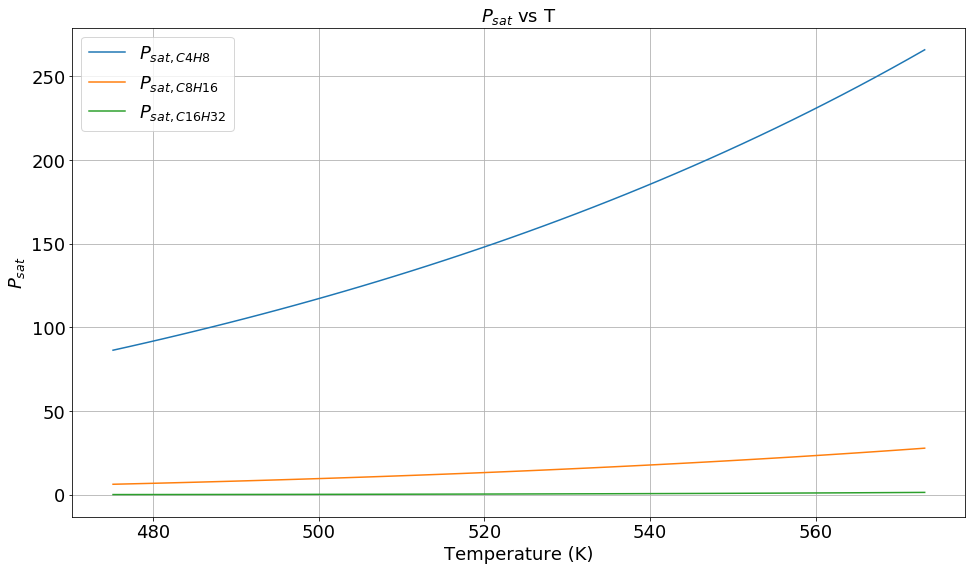

In [22]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['P_sat','C4H8'])
ax.plot(rf_data['T'],rf_data['P_sat','C8H16'])
ax.plot(rf_data['T'],rf_data['P_sat','C16H32'])
ax.set_ylabel('$P_{sat}$ (bar)', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.legend(['$P_{sat,C4H8}$','$P_{sat,C8H16}$','$P_{sat,C16H32}$'],fontsize=18)
ax.set_title('$P_{sat}$ vs T',fontsize=18)
plt.show()

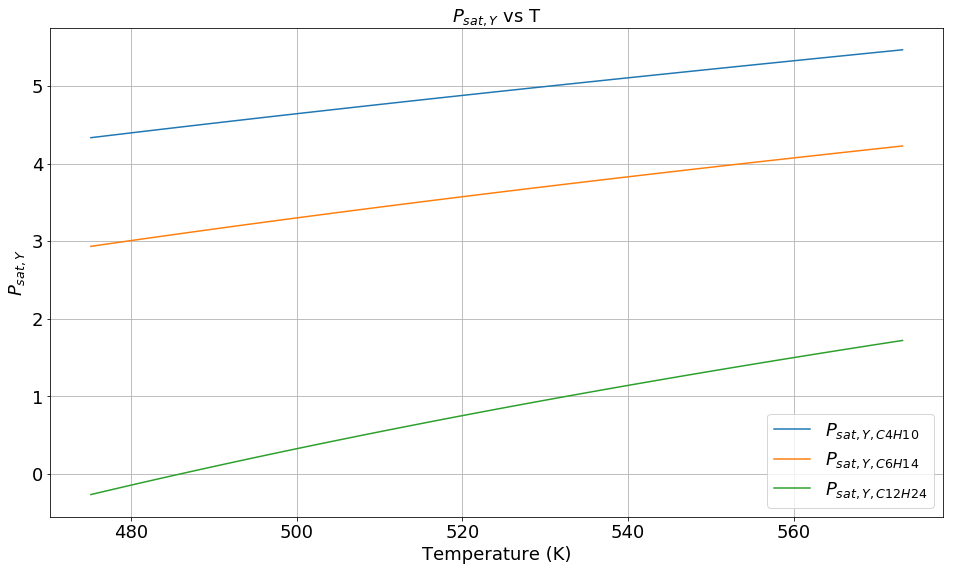

In [23]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['P_sat_Y','C4H10'])
ax.plot(rf_data['T'],rf_data['P_sat_Y','C6H14'])
ax.plot(rf_data['T'],rf_data['P_sat_Y','C12H24'])
ax.set_ylabel('$P_{sat,Y}$', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.legend(['$P_{sat,Y,C4H10}$','$P_{sat,Y,C6H14}$','$P_{sat,Y,C12H24}$'],fontsize=18)
ax.set_title('$P_{sat,Y}$ vs T',fontsize=18)
plt.show()

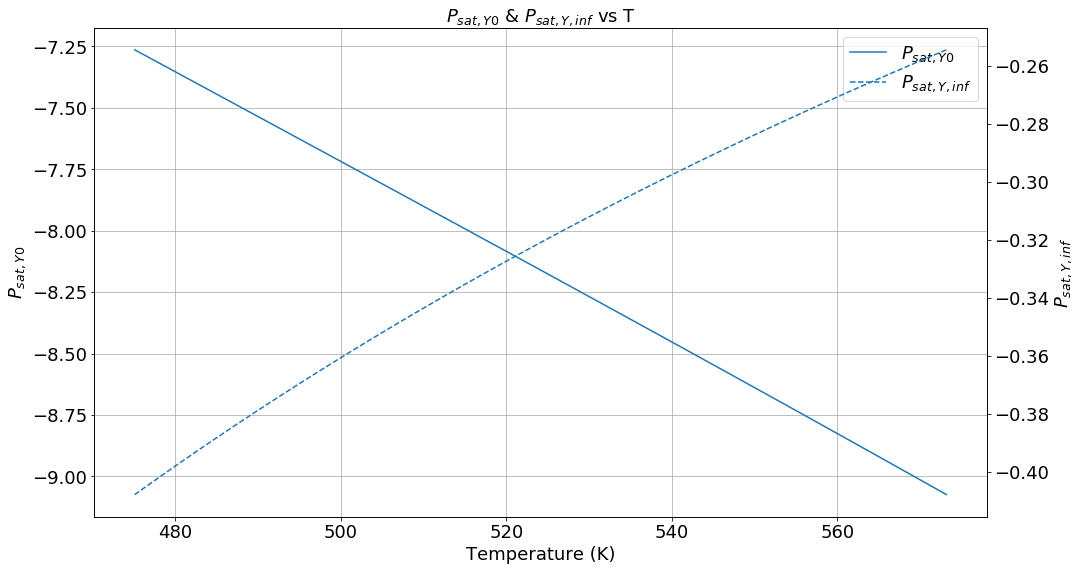

In [24]:
fig, ax1 = plt.subplots(figsize=(16,9))
line1 = ax1.plot(rf_data['T'],rf_data['P_sat_dY0'])
ax1.set_ylabel('$P_{sat,Y0}$', color='K',fontsize=18)
ax1.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax1.tick_params('y', colors='k',labelsize=18)
ax1.tick_params('x', colors='k',labelsize=18)
ax1.grid()

ax2 = ax1.twinx()
line2 = ax2.plot(rf_data['T'],rf_data['P_sat_dY_inf'], '--')
ax2.set_ylabel('$P_{sat,Y,inf}$', color='K',fontsize=18)
ax2.tick_params('y', colors='k',labelsize=18)

ax1.legend(line1+line2,['$P_{sat,Y0}$','$P_{sat,Y,inf}$'],fontsize=18)
ax1.set_title('$P_{sat,Y0}$ & $P_{sat,Y,inf}$ vs T',fontsize=18)
plt.show()

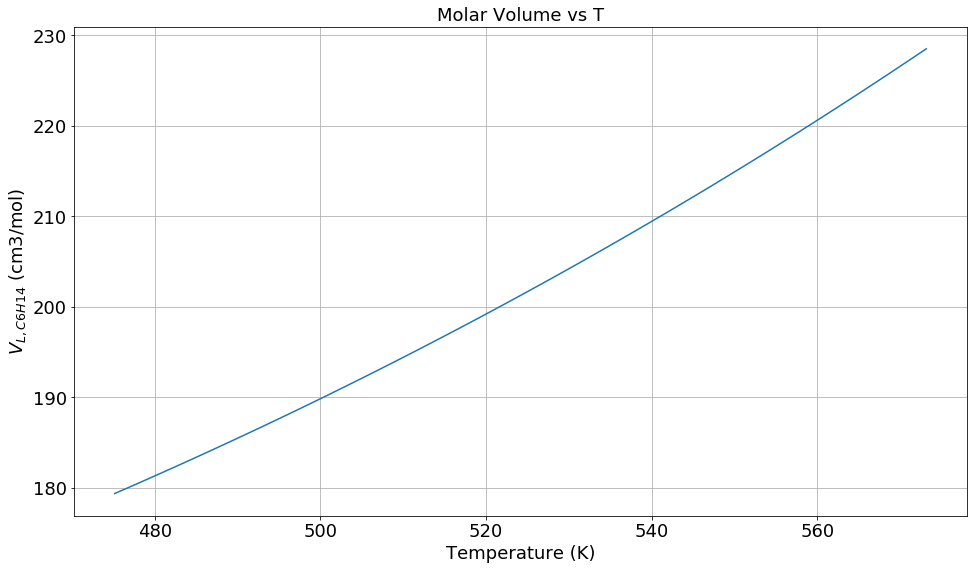

In [25]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['V_L','C6H14'])
ax.set_ylabel('$V_{L,C6H14}$ (cm3/mol)', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.set_title('Molar Volume vs T',fontsize=18)
plt.show()

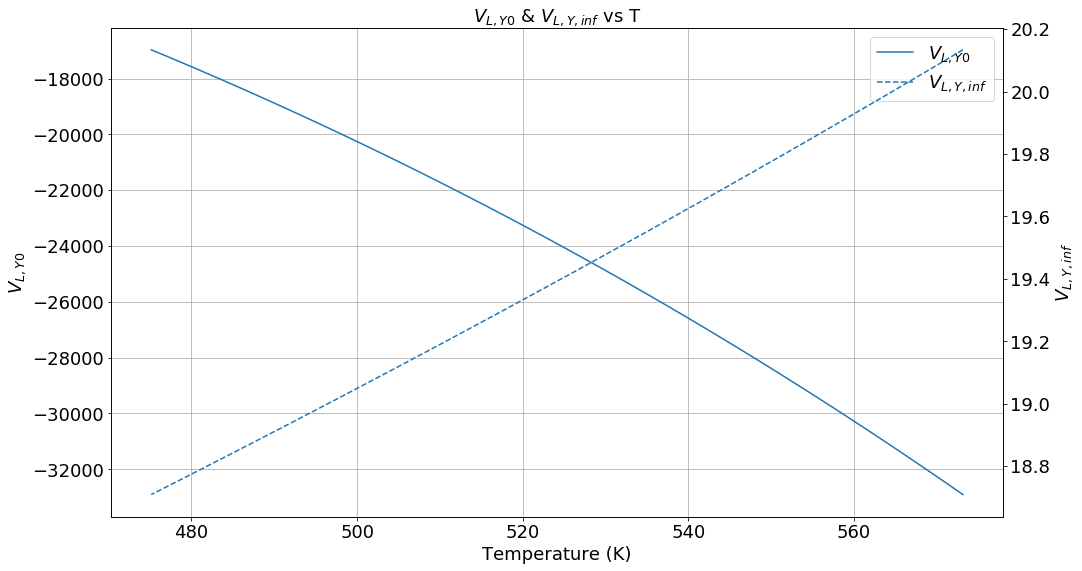

In [26]:
fig, ax1 = plt.subplots(figsize=(16,9))
line1 = ax1.plot(rf_data['T'],rf_data['V_L_dY0'])
ax1.set_ylabel('$V_{L,Y0}$', color='K',fontsize=18)
ax1.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax1.tick_params('y', colors='k',labelsize=18)
ax1.tick_params('x', colors='k',labelsize=18)
ax1.grid()

ax2 = ax1.twinx()
line2 = ax2.plot(rf_data['T'],rf_data['V_L_dY_inf'], '--')
ax2.set_ylabel('$V_{L,Y,inf}$', color='K',fontsize=18)
ax2.tick_params('y', colors='k',labelsize=18)

ax1.legend(line1+line2,['$V_{L,Y0}$','$V_{L,Y,inf}$'],fontsize=18)
ax1.set_title('$V_{L,Y0}$ & $V_{L,Y,inf}$ vs T',fontsize=18)
plt.show()

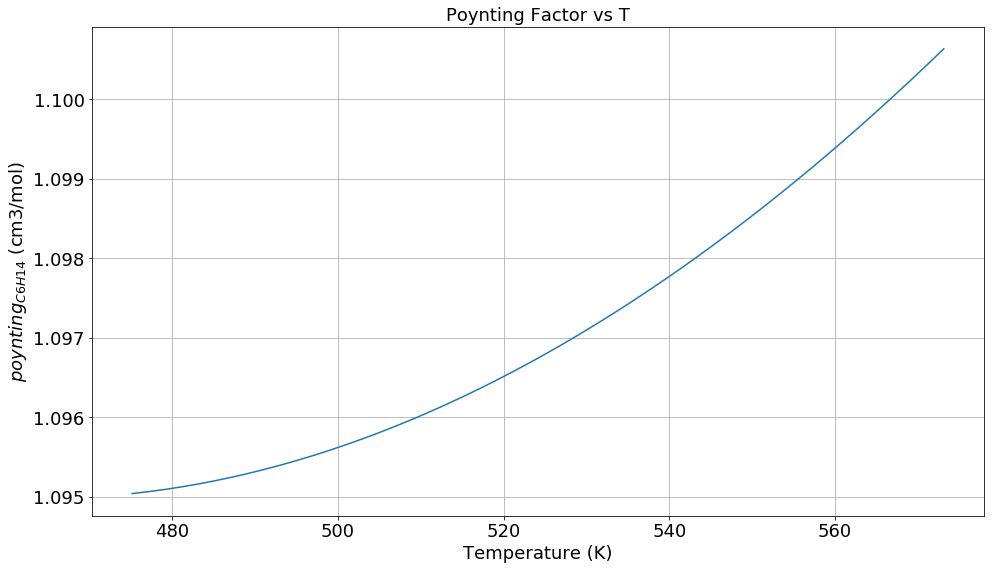

In [27]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(rf_data['T'],rf_data['poynting','C6H14'])
ax.set_ylabel('$poynting_{C6H14}$ (cm3/mol)', color='K',fontsize=18)
ax.set_xlabel('Temperature (K)', color='K',fontsize=18)
ax.tick_params('y', colors='k',labelsize=18)
ax.tick_params('x', colors='k',labelsize=18)
ax.grid()

ax.set_title('Poynting Factor vs T',fontsize=18)
plt.show()